In [259]:
from dataclasses import dataclass ,field
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

@dataclass

class BeamGeometry:
    width:float   # mm
    depth:float   # mm
    length:float  # mm
    cover: float  # mm
    eff_depth: float = field(init=False)

    def __post_init__(self):
        self.eff_depth = self.depth - 2 * self.cover
    

In [ ]:
@dataclass

class Loading:
    bearing_wdith:float 
    bearing_length:float
    magnitude:float # kN
    location:float # mm from left support

In [261]:
@dataclass

class Materials:
    fc:float  # Mpa
    fy:float  # Mpa
    phi:float 


In [ ]:
@dataclass

class Supoort:
    bearing_wdith:float 
    bearing_length:float

In [262]:
import math
@dataclass

class Checks:
    def DeepBeam(beam:BeamGeometry,load:Loading)->tuple[bool, str]:
        result = beam.length<=4*beam.depth or load.location<=2*beam.depth
        if result:
            desc="The Given Beam is Deep"
        else:
            desc="The Given Beam is not Deep"
        return result,desc
    def ShearCapacity(beam:BeamGeometry,load:Loading,material:Materials)->tuple[bool,str]:
        result=load.magnitude/2<=material.phi*0.83*math.sqrt(material.fc)*beam.width*beam.depth
        if result:
            desc="SHEAR CAPACITY IS OK NO NEED TO REVISE DIMENSION"
        else:
            desc="SHEAR CAPACITY IS NOT OK  NEED TO REVISE DIMENSION"
        return result,desc
    def BearingCapacityNodes(beam:BeamGeometry,load:Loading,material:Materials)->tuple[bool,str]:
        result=load.magnitude/2<=material.phi*0.83*math.sqrt(material.fc)*beam.width*beam.depth
        if result:
            desc="SHEAR CAPACITY IS OK NO NEED TO REVISE DIMENSION"
        else:
            desc="SHEAR CAPACITY IS NOT OK  NEED TO REVISE DIMENSION"
        return result,desc
    
    

In [264]:
Deep_Beam_Check=Checks.DeepBeam(Beam,Load)
Deep_Beam_Check

(False, 'The Given Beam is not Deep')

In [265]:
Shear_Capacity_Check=Checks.DeepBeam(Beam,Load)
Shear_Capacity_Check

(False, 'The Given Beam is not Deep')

In [266]:
from dataclasses import dataclass ,field
@dataclass
class Strut_Tie_Model :
    beam:BeamGeometry
    load:Loading
    target_angle_deg:float

    R_right: float = field(init=False)
    R_left: float = field(init=False)
    nodes: list = field(default_factory=list)
    members: list = field(default_factory=list)
    node_map: dict = field(default_factory=dict)
    node_idx: int = field(default=0)
    left_nodes_bottom: list = field(default_factory=list)
    left_nodes_top: list = field(default_factory=list)
    right_nodes_bottom: list = field(default_factory=list)
    right_nodes_top: list = field(default_factory=list)
    bottom_chord_nodes: list = field(default_factory=list)

    def __post_init__(self):
        self.R_right = self.load.magnitude * self.load.location/ self.beam.length
        self.R_left = self.load.magnitude-self.R_right
        print(f"Left Support: {self.R_right:.2f} kN")
        print(f"Right Support: {self.R_left:.2f} kN")
        self.dx = self.beam.eff_depth/ np.tan(np.radians(self.target_angle_deg))
        self.theta_rad = np.radians(self.target_angle_deg)
        print(f"Panel width (dx): {self.dx:.2f} mm")
        print(f"Strut angle: {self.target_angle_deg:.2f}°")
        self.current_x_bottom = self.load.location
        while self.current_x_bottom - self.dx >= 0:
            self.next_x_bottom = self.current_x_bottom - self.dx
            if self.next_x_bottom < 0:
                self.next_x_bottom = 0
        
            self.left_nodes_bottom.insert(0, self.next_x_bottom)
        
            if self.next_x_bottom > 0:
                self.left_nodes_top.insert(0, self.next_x_bottom)
                self.current_x_bottom = self.next_x_bottom
            else:
                break
    
        if len(self.left_nodes_bottom) == 0 or self.left_nodes_bottom[0] > 0:
            self.left_nodes_bottom.insert(0, 0)
        

        self.current_x_bottom = self.load.location
    
        while self.current_x_bottom + self.dx <= self.beam.length:
            self.next_x_bottom = self.current_x_bottom + self.dx
            if self.next_x_bottom > self.beam.length:
                self.next_x_bottom = self.beam.length
        
            self.right_nodes_bottom.append(self.next_x_bottom)
        
            if self.next_x_bottom < self.beam.length:
                self.right_nodes_top.append(self.next_x_bottom)
                self.current_x_bottom = self.next_x_bottom
            else:
                break
    
        if len(self.right_nodes_bottom) == 0 or self.right_nodes_bottom[-1] < self.beam.length:
            self.right_nodes_bottom.append(self.beam.length)
 
        self.nodes.append({'x': 0, 'y': 0, 'type': 'support', 'label': 'L_Sup'})
        self.node_map['support_left'] = self.node_idx
        self.node_idx += 1
        
        for i, x in enumerate(self.left_nodes_bottom[1:]):
            self.nodes.append({'x': x, 'y': 0, 'type': 'joint', 'label': f'LB{i}'})
            self.node_map[f'left_bot_{i}'] = self.node_idx
            self.node_idx += 1
        
        for i, x in enumerate(self.left_nodes_top):
            self.nodes.append({'x': x, 'y': self.beam.eff_depth, 'type': 'joint', 'label': f'LT{i}'})
            self.node_map[f'left_top_{i}'] = self.node_idx
            self.node_idx += 1
        
        self.nodes.append({'x': self.load.location, 'y':self.beam.eff_depth, 'type': 'load', 'label': 'Load'})
        self.node_map['load'] = self.node_idx
        self.node_idx += 1
        
        for i, x in enumerate(self.right_nodes_top):
            self.nodes.append({'x': x, 'y': self.beam.eff_depth, 'type': 'joint', 'label': f'RT{i}'})
            self.node_map[f'right_top_{i}'] = self.node_idx
            self.node_idx += 1
        
        for i, x in enumerate(self.right_nodes_bottom[:-1]):
            self.nodes.append({'x': x, 'y': 0, 'type': 'joint', 'label': f'RB{i}'})
            self.node_map[f'right_bot_{i}'] = self.node_idx
            self.node_idx += 1
        
        self.nodes.append({'x': self.beam.length, 'y': 0, 'type': 'support', 'label': 'R_Sup'})
        self.node_map['support_right'] = self.node_idx
        self.node_idx += 1
        
        # ===== CREATE MEMBERS =====
        
        # LEFT SIDE DIAGONALS AND VERTICALS
        if len(self.left_nodes_bottom) > 1:
            self.members.append({
                'start': self.node_map['load'],
                'end': self.node_map.get(f'left_bot_{len(self.left_nodes_bottom)-2}', self.node_map['support_left']),
                'type': 'compression',
                'force': 0
            })
            
            for i in range(len(self.left_nodes_top)):
                self.members.append({
                    'start': self.node_map.get(f'left_bot_{len(self.left_nodes_bottom)-2-i}', self.node_map['support_left']),
                    'end': self.node_map[f'left_top_{len(self.left_nodes_top)-1-i}'],
                    'type': 'tension',
                    'force': 0
                })
                
                if i < len(self.left_nodes_top) - 1:
                    self.members.append({
                        'start': self.node_map[f'left_top_{len(self.left_nodes_top)-1-i}'],
                        'end': self.node_map.get(f'left_bot_{len(self.left_nodes_bottom)-3-i}', self.node_map['support_left']),
                        'type': 'compression',
                        'force': 0
                    })
                else:
                    self.members.append({
                        'start': self.node_map[f'left_top_{0}'],
                        'end': self.node_map['support_left'],
                        'type': 'compression',
                        'force': 0
                    })
        else:
            self.members.append({
                'start': self.node_map['load'],
                'end': self.node_map['support_left'],
                'type': 'compression',
                'force': 0
            })
        
        # RIGHT SIDE DIAGONALS AND VERTICALS
        if len(self.right_nodes_bottom) > 1:
            self.members.append({
                'start': self.node_map['load'],
                'end': self.node_map.get(f'right_bot_0', self.node_map['support_right']),
                'type': 'compression',
                'force': 0
            })
            
            for i in range(len(self.right_nodes_top)):
                self.members.append({
                    'start': self.node_map.get(f'right_bot_{i}', self.node_map['support_right']),
                    'end': self.node_map[f'right_top_{i}'],
                    'type': 'tension',
                    'force': 0
                })
                
                if i < len(self.right_nodes_top) - 1:
                    self.members.append({
                        'start': self.node_map[f'right_top_{i}'],
                        'end': self.node_map.get(f'right_bot_{i+1}', self.node_map['support_right']),
                        'type': 'compression',
                        'force': 0
                    })
                else:
                    self.members.append({
                        'start': self.node_map[f'right_top_{len(self.right_nodes_top)-1}'],
                        'end': self.node_map['support_right'],
                        'type': 'compression',
                        'force': 0
                    })
        else:
            self.members.append({
                'start': self.node_map['load'],
                'end': self.node_map['support_right'],
                'type': 'compression',
                'force': 0
            })
        
        # TOP CHORD MEMBERS
        for i in range(len(self.left_nodes_top) - 1):
            self.members.append({
                'start': self.node_map[f'left_top_{i}'],
                'end': self.node_map[f'left_top_{i+1}'],
                'type': 'compression',
                'force': 0
            })
        if len(self.left_nodes_top) > 0:
            self.members.append({
                'start': self.node_map[f'left_top_{len(self.left_nodes_top)-1}'],
                'end': self.node_map['load'],
                'type': 'compression',
                'force': 0
            })
        
        if len(self.right_nodes_top) > 0:
            self.members.append({
                'start': self.node_map['load'],
                'end': self.node_map[f'right_top_0'],
                'type': 'compression',
                'force': 0
            })
        for i in range(len(self.right_nodes_top) - 1):
            self.members.append({
                'start': self.node_map[f'right_top_{i}'],
                'end': self.node_map[f'right_top_{i+1}'],
                'type': 'compression',
                'force': 0
            })
        
        # BOTTOM CHORD MEMBERS
        ##############################################################
        self.all_bottom_x = sorted([0] + self.left_nodes_bottom[1:] +self. right_nodes_bottom[:-1] + [self.beam.length])
        for x in self.all_bottom_x:
            for key, idx in self.node_map.items():
                if self.nodes[idx]['y'] == 0 and abs(self.nodes[idx]['x'] - x) < 0.1:
                    self.bottom_chord_nodes.append(idx)
                    break
        
        for i in range(len(self.bottom_chord_nodes) - 1):
            self.members.append({
                'start': self.bottom_chord_nodes[i],
                'end': self.bottom_chord_nodes[i+1],
                'type': 'tension',
                'force': 0
            })
        self.calculate_forces_method_of_joints(self.nodes, self.members, self.node_map,self.R_right, self.R_left, self.load.magnitude, self.beam.eff_depth)
        self.plot_stm(self.beam.length, self.beam.eff_depth, self.nodes, self.members, self.load.location, self.load.magnitude)
   
    def calculate_forces_method_of_joints(self,nodes, members, node_map, R_left, R_right, load_mag, height):
        """Calculate member forces using method of joints"""
        
        print(f"\n=== METHOD OF JOINTS - FORCE CALCULATION ===")
        
        # Create adjacency list for each node
        self.node_members = {i: [] for i in range(len(self.nodes))}
        for m_idx, m in enumerate(self.members):
            self.node_members[m['start']].append(m_idx)
            self.node_members[m['end']].append(m_idx)
        
        # Track solved members
        self.solved = [False] * len(self.members)
        
        # Process joints in order from supports to load
        # Start with left support
        self.process_joint(node_map['support_left'], nodes, members, self.node_members, self.solved, 
                    external_x=0, external_y=R_left)
        
        # Process right support
        self.process_joint(node_map['support_right'], nodes, members, self.node_members, self.solved,
                    external_x=0, external_y=R_right)
        
        # Process remaining joints iteratively
        max_iterations = len(nodes) * 2
        iteration = 0
        while not all(self.solved) and iteration < max_iterations:
            iteration += 1
            for node_idx in range(len(nodes)):
                if node_idx == node_map['load']:
                    continue  # Process load point last
                
                # Count unknowns at this joint
                connected = self.node_members[node_idx]
                unknowns = sum(1 for m_idx in connected if not self.solved[m_idx])
                
                if unknowns <= 2 and unknowns > 0:
                    ext_x, ext_y = 0, 0
                    if node_idx == node_map['support_left']:
                        ext_y = R_left
                    elif node_idx == node_map['support_right']:
                        ext_y = R_right
                    
                    self.process_joint(node_idx, nodes, members, self.node_members, self.solved, ext_x, ext_y)
        
        # Finally process load point
        self.process_joint(node_map['load'], nodes, members, self.node_members, self.solved,
                    external_x=0, external_y=-load_mag)
        
        # Print results
        print(f"\n=== MEMBER FORCES ===")
        for i, m in enumerate(members):
            n1 = nodes[m['start']]
            n2 = nodes[m['end']]
            force_type = "C" if m['type'] == 'compression' else "T"
            print(f"Member {i}: ({n1['label']} to {n2['label']}) = {abs(m['force']):.2f} kN ({force_type})")

    def process_joint(self,node_idx, nodes, members, node_members, solved, external_x=0, external_y=0):
        """Solve equilibrium at a joint"""
        
        node = nodes[node_idx]
        connected = node_members[node_idx]
        
        # Count unknowns
        unknowns = [m_idx for m_idx in connected if not solved[m_idx]]
        knowns = [m_idx for m_idx in connected if solved[m_idx]]
        
        if len(unknowns) == 0:
            return
        
        # Sum known forces
        sum_x = external_x
        sum_y = external_y
        
        for m_idx in knowns:
            m = members[m_idx]
            n1 = nodes[m['start']]
            n2 = nodes[m['end']]
            
            # Determine direction (force points away from joint for tension, towards for compression)
            if m['start'] == node_idx:
                dx = n2['x'] - n1['x']
                dy = n2['y'] - n1['y']
            else:
                dx = n1['x'] - n2['x']
                dy = n1['y'] - n2['y']
            
            length = np.sqrt(dx**2 + dy**2)
            if length == 0:
                continue
            
            cos_theta = dx / length
            sin_theta = dy / length
            
            # Force is positive for tension (pulling away), negative for compression (pushing in)
            F = m['force']
            sum_x += F * cos_theta
            sum_y += F * sin_theta
        
        # Solve for unknowns
        if len(unknowns) == 1:
            # One unknown - solve directly
            m_idx = unknowns[0]
            m = members[m_idx]
            n1 = nodes[m['start']]
            n2 = nodes[m['end']]
            
            if m['start'] == node_idx:
                dx = n2['x'] - n1['x']
                dy = n2['y'] - n1['y']
            else:
                dx = n1['x'] - n2['x']
                dy = n1['y'] - n2['y']
            
            length = np.sqrt(dx**2 + dy**2)
            if length > 0:
                cos_theta = dx / length
                sin_theta = dy / length
                
                # Use the direction with larger component
                if abs(cos_theta) > abs(sin_theta):
                    F = -sum_x / cos_theta
                else:
                    F = -sum_y / sin_theta
                
                m['force'] = F
                solved[m_idx] = True
        
        elif len(unknowns) == 2:
            # Two unknowns - solve system of equations
            m_idx1, m_idx2 = unknowns
            m1 = members[m_idx1]
            m2 = members[m_idx2]
            
            # Get directions for both members
            n1_1 = nodes[m1['start']]
            n2_1 = nodes[m1['end']]
            if m1['start'] == node_idx:
                dx1 = n2_1['x'] - n1_1['x']
                dy1 = n2_1['y'] - n1_1['y']
            else:
                dx1 = n1_1['x'] - n2_1['x']
                dy1 = n1_1['y'] - n2_1['y']
            
            length1 = np.sqrt(dx1**2 + dy1**2)
            if length1 == 0:
                return
            cos1 = dx1 / length1
            sin1 = dy1 / length1
            
            n1_2 = nodes[m2['start']]
            n2_2 = nodes[m2['end']]
            if m2['start'] == node_idx:
                dx2 = n2_2['x'] - n1_2['x']
                dy2 = n2_2['y'] - n1_2['y']
            else:
                dx2 = n1_2['x'] - n2_2['x']
                dy2 = n1_2['y'] - n2_2['y']
            
            length2 = np.sqrt(dx2**2 + dy2**2)
            if length2 == 0:
                return
            cos2 = dx2 / length2
            sin2 = dy2 / length2
            
            # Solve system: cos1*F1 + cos2*F2 = -sum_x
            #               sin1*F1 + sin2*F2 = -sum_y
            
            det = cos1 * sin2 - cos2 * sin1
            if abs(det) > 1e-6:
                F1 = (-sum_x * sin2 + sum_y * cos2) / det
                F2 = (-sum_y * cos1 + sum_x * sin1) / det
                
                m1['force'] = F1
                m2['force'] = F2
                solved[m_idx1] = True
                solved[m_idx2] = True

    def plot_stm(self,length, height, nodes, members, load_x, load_mag):
        """Plot the STM truss structure with force labels"""
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_aspect('equal')
        
        # Draw boundary
        total_h = height * 1.4
        margin = (total_h - height) / 2
        ax.add_patch(plt.Rectangle((0, -margin), length, total_h, 
                                fill=False, ec='black', lw=2))
        
        # Draw members with force labels
        for m in members:
            n1 = nodes[m['start']]
            n2 = nodes[m['end']]
            
            if m['type'] == 'compression':
                color = '#d62728'  # Red
                lw = 2.5
            else:
                color = '#1f77b4'  # Blue
                lw = 2.5
            
            ax.plot([n1['x'], n2['x']], [n1['y'], n2['y']], 
                    color=color, linewidth=lw, alpha=0.8, zorder=1)
            
            # Add force label at midpoint
            mid_x = (n1['x'] + n2['x']) / 2
            mid_y = (n1['y'] + n2['y']) / 2
            force_val = abs(m['force'])
            
            # Calculate rotation angle
            dx = n2['x'] - n1['x']
            dy = n2['y'] - n1['y']
            
            if abs(dx) < 1:  # Vertical member
                rot = 90
                offset_x = height * 0.05
                mid_x += offset_x
            elif abs(dy) < 1:  # Horizontal member
                rot = 0
                offset_y = height * 0.08 if mid_y > 0 else -height * 0.08
                mid_y += offset_y
            else:  # Diagonal member
                angle = np.degrees(np.arctan2(dy, dx))
                if angle > 90:
                    angle -= 180
                if angle < -90:
                    angle += 180
                rot = angle
            
            ax.text(mid_x, mid_y, f"{force_val:.1f}", 
                    fontsize=9, fontweight='bold', 
                    color='darkgreen', rotation=rot, 
                    ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, pad=1))
        
        # Draw nodes
        for n in nodes:
            if n['type'] == 'load':
                c = 'red'
                size = 12
            elif n['type'] == 'support':
                c = 'green'
                size = 12
            else:
                c = 'blue'
                size = 10
            
            ax.plot(n['x'], n['y'], marker='o', color=c, 
                markersize=size, markeredgecolor='black', 
                markeredgewidth=1.5, zorder=2)
        
        # Draw load arrow
        arrow_start_y = height + height * 0.25
        ax.add_patch(FancyArrowPatch((load_x, arrow_start_y), (load_x, height),
                                    arrowstyle='->,head_width=0.4,head_length=0.4', 
                                    mutation_scale=40, color='black', lw=2.5))
        ax.text(load_x, arrow_start_y + height * 0.08, f"{int(load_mag)} kN", 
            ha='center', fontsize=12, fontweight='bold')
        
        ax.set_title(f"Cascading STM Truss - Member Forces (kN)", 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.tight_layout()
        plt.show()



    


Left Support: 50.00 kN
Right Support: 50.00 kN
Panel width (dx): 500.08 mm
Strut angle: 40.36°

=== METHOD OF JOINTS - FORCE CALCULATION ===

=== MEMBER FORCES ===
Member 0: (Load to LB3) = 77.21 kN (C)
Member 1: (LB3 to LT3) = 50.00 kN (T)
Member 2: (LT3 to LB2) = 77.21 kN (C)
Member 3: (LB2 to LT2) = 50.00 kN (T)
Member 4: (LT2 to LB1) = 77.21 kN (C)
Member 5: (LB1 to LT1) = 50.00 kN (T)
Member 6: (LT1 to LB0) = 77.21 kN (C)
Member 7: (LB0 to LT0) = 50.00 kN (T)
Member 8: (LT0 to L_Sup) = 77.17 kN (C)
Member 9: (Load to RB0) = 77.21 kN (C)
Member 10: (RB0 to RT0) = 50.00 kN (T)
Member 11: (RT0 to RB1) = 77.21 kN (C)
Member 12: (RB1 to RT1) = 50.00 kN (T)
Member 13: (RT1 to RB2) = 77.21 kN (C)
Member 14: (RB2 to RT2) = 50.00 kN (T)
Member 15: (RT2 to RB3) = 77.21 kN (C)
Member 16: (RB3 to RT3) = 50.00 kN (T)
Member 17: (RT3 to R_Sup) = 77.17 kN (C)
Member 18: (LT0 to LT1) = 58.79 kN (C)
Member 19: (LT1 to LT2) = 117.62 kN (C)
Member 20: (LT2 to LT3) = 176.45 kN (C)
Member 21: (LT3 to 

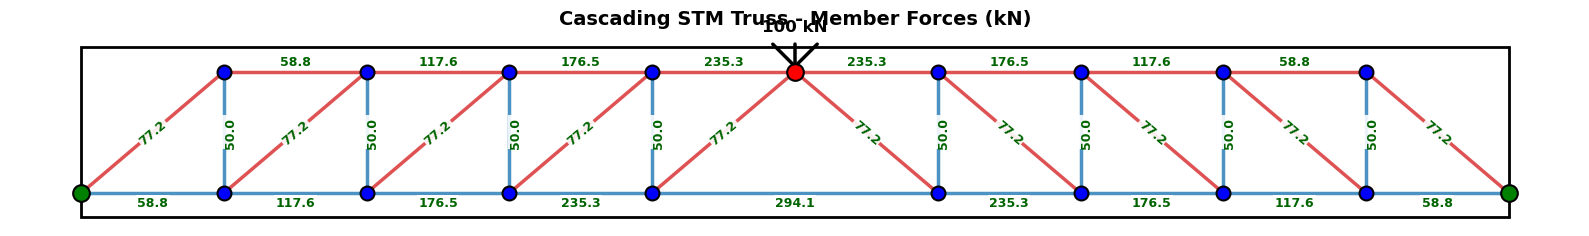

              x      y     type  label
0      0.000000    0.0  support  L_Sup
1    499.679066    0.0    joint    LB0
2    999.759299    0.0    joint    LB1
3   1499.839533    0.0    joint    LB2
4   1999.919766    0.0    joint    LB3
5    499.679066  425.0    joint    LT0
6    999.759299  425.0    joint    LT1
7   1499.839533  425.0    joint    LT2
8   1999.919766  425.0    joint    LT3
9   2500.000000  425.0     load   Load
10  3000.080234  425.0    joint    RT0
11  3500.160467  425.0    joint    RT1
12  4000.240701  425.0    joint    RT2
13  4500.320934  425.0    joint    RT3
14  3000.080234    0.0    joint    RB0
15  3500.160467    0.0    joint    RB1
16  4000.240701    0.0    joint    RB2
17  4500.320934    0.0    joint    RB3
18  5000.000000    0.0  support  R_Sup


In [ ]:
a=Strut_Tie_Model(Beam,Load,40.36)
import pandas as pd
df_nodes = pd.DataFrame(a.nodes)
print(df_nodes)


In [268]:
# I want type load as lebelled as CCC , type support CCT , joint whose y!=0 as CCT and joint whose whose y=0 as CTT node
import pandas as pd

class NodeAnalysis:
    def __init__(self, stm_instance): 
        self.nodes_raw = stm_instance.nodes
        self.df = pd.DataFrame(self.nodes_raw)
        self.classify_nodes()
        self.assign_beta_factors()

    def classify_nodes(self):
        """
        Applies STM classification:
        - Type 'load' -> CCC
        - Type 'support' -> CCT
        - Joint with y != 0 -> CCT
        - Joint with y == 0 -> CTT
        """
        def get_stm_type(row):
            if row['type'] == 'load':
                return 'CCC'
            elif row['type'] == 'support':
                return 'CCT'
            elif row['type'] == 'joint':
                return 'CCT' if row['y'] != 0 else 'CTT'
            return 'Unknown'

        self.df['stm_type'] = self.df.apply(get_stm_type, axis=1)

    def assign_beta_factors(self):
        """
        Assigns Beta_n based on ACI 318 Table 23.4.3(a)
        """
        # Mapping based on ACI standards
        beta_n_values = {
            'CCC': 1.0,
            'CCT': 0.80,
            'CTT': 0.60
        }
        self.df['beta_n'] = self.df['stm_type'].map(beta_n_values)

    def get_summary(self):
        return self.df[['label', 'x', 'y', 'stm_type', 'beta_n']]

# --- Usage ---
# Assuming 'a' is your Strut_Tie_Model instance:
# analysis = NodeAnalysis(a)
# print(analysis.get_summary())
        
        



In [269]:
# I want type load as lebelled as CCC , type support CCT , joint whose y!=0 as CCT and joint whose whose y=0 as CTT node
b=NodeAnalysis(a)
print(b)

In [270]:
# --- Usage ---
# Assuming 'a' is your Strut_Tie_Model instance:


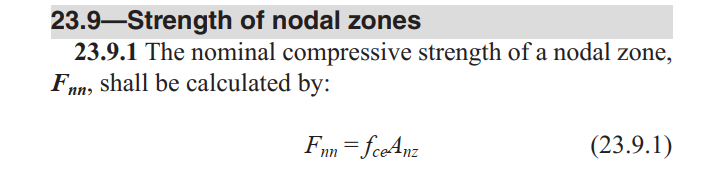

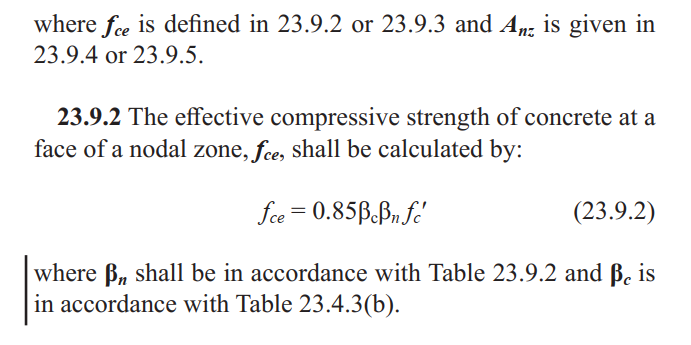

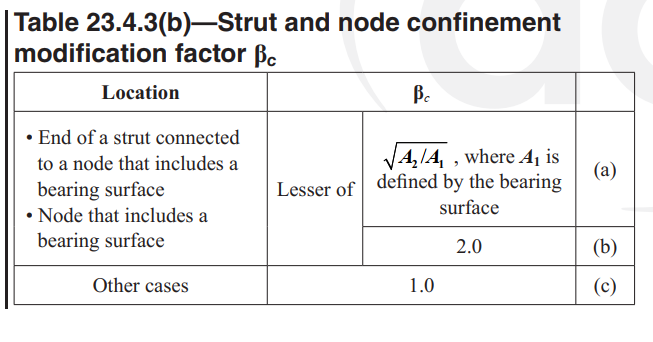


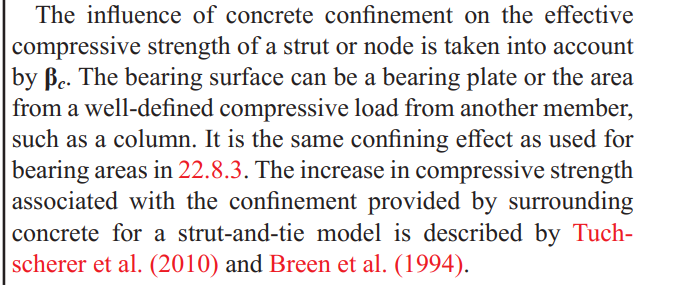

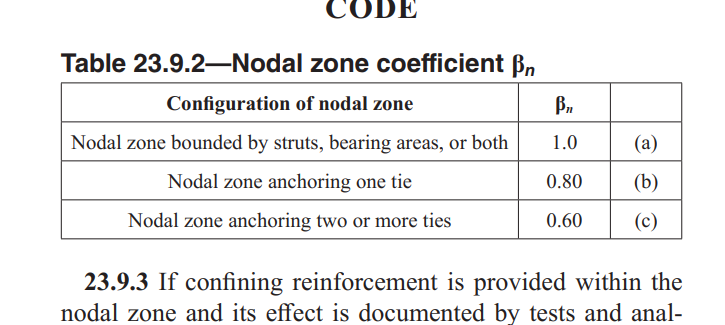

In [271]:
analysis = NodeAnalysis(a)
print(analysis.get_summary())

    label            x      y stm_type  beta_n
0   L_Sup     0.000000    0.0      CCT     0.8
1     LB0   499.679066    0.0      CTT     0.6
2     LB1   999.759299    0.0      CTT     0.6
3     LB2  1499.839533    0.0      CTT     0.6
4     LB3  1999.919766    0.0      CTT     0.6
5     LT0   499.679066  425.0      CCT     0.8
6     LT1   999.759299  425.0      CCT     0.8
7     LT2  1499.839533  425.0      CCT     0.8
8     LT3  1999.919766  425.0      CCT     0.8
9    Load  2500.000000  425.0      CCC     1.0
10    RT0  3000.080234  425.0      CCT     0.8
11    RT1  3500.160467  425.0      CCT     0.8
12    RT2  4000.240701  425.0      CCT     0.8
13    RT3  4500.320934  425.0      CCT     0.8
14    RB0  3000.080234    0.0      CTT     0.6
15    RB1  3500.160467    0.0      CTT     0.6
16    RB2  4000.240701    0.0      CTT     0.6
17    RB3  4500.320934    0.0      CTT     0.6
18  R_Sup  5000.000000    0.0      CCT     0.8


In [272]:
# class NodeAnalysis:
#     def __init__(self, stm_instance): 
#         self.stm = stm_instance
#         self.nodes_raw = stm_instance.nodes
#         self.members = stm_instance.members
#         self.df = pd.DataFrame(self.nodes_raw)
#         self.classify_nodes()
#         self.assign_beta_factors()
#         self.add_member_forces()

#     def classify_nodes(self):
#         def get_stm_type(row):
#             if row['type'] == 'load':
#                 return 'CCC'
#             elif row['type'] == 'support':
#                 return 'CCT'
#             elif row['type'] == 'joint':
#                 return 'CCT' if row['y'] != 0 else 'CTT'
#             return 'Unknown'
#         self.df['stm_type'] = self.df.apply(get_stm_type, axis=1)

#     def assign_beta_factors(self):
#         beta_n_values = {'CCC': 1.0, 'CCT': 0.80, 'CTT': 0.60}
#         self.df['beta_n'] = self.df['stm_type'].map(beta_n_values)

#     def add_member_forces(self):
#         # Find all members connected to each node
#         for idx in range(len(self.df)):
#             connected = [m for m in self.members if m['start'] == idx or m['end'] == idx]
#             for i, m in enumerate(connected, 1):
#                 self.df.loc[idx, f'Member_{i}'] = abs(m['force'])
    
#     def to_excel(self, filename='node_analysis.xlsx'):
#         self.get_summary().to_excel(filename, index=False)
#         print(f"✓ Exported to {filename}")


#     def get_summary(self):
#         return self.df

# # Usage
# analysis = NodeAnalysis(a)
# print(analysis.get_summary())
# analysis.to_excel('strut_tie_analysis.xlsx')

In [273]:
class NodeAnalysis:
    def __init__(self, stm_instance): 
        self.stm = stm_instance
        self.nodes_raw = stm_instance.nodes
        self.members = stm_instance.members
        self.df = pd.DataFrame(self.nodes_raw)
        self.classify_nodes()
        self.assign_beta_factors()
        self.add_member_forces()
        self.df['Bc'] = 1

    def classify_nodes(self):
        def get_stm_type(row):
            if row['type'] == 'load':
                return 'CCC'
            elif row['type'] == 'support':
                return 'CCT'
            elif row['type'] == 'joint':
                return 'CCT' if row['y'] != 0 else 'CTT'
            return 'Unknown'
        self.df['stm_type'] = self.df.apply(get_stm_type, axis=1)

    def assign_beta_factors(self):
        beta_n_values = {'CCC': 1.0, 'CCT': 0.80, 'CTT': 0.60}
        self.df['beta_n'] = self.df['stm_type'].map(beta_n_values)



    def add_member_forces(self):
        self.member_info = {}  # Store member type info
        max_members = 0
        
        for idx in range(len(self.df)):
            connected = [(abs(m['force']), m['type'], m['force']) 
                        for m in self.members if m['start'] == idx or m['end'] == idx]
            max_members = max(max_members, len(connected))
            
            for i, (force, mtype, signed_force) in enumerate(connected, 1):
                col_name = f'Member_{i}'
                # Add sign prefix
                sign = '+' if signed_force > 0 else '-'
                self.df.loc[idx, col_name] = f"{sign}{force:.1f}"
                # Store type for coloring
                self.member_info[(idx, col_name)] = mtype
        
        for i in range(1, max_members + 1):
            if f'Member_{i}' in self.df.columns:
                self.df[f'Member_{i}'].fillna('', inplace=True)

    def get_summary(self):
        return self.df[['label', 'x', 'y', 'stm_type', 'beta_n','Bc'] + 
                       [col for col in self.df.columns if col.startswith('Member_')]]

    
    def to_excel(self, filename='node_analysis.xlsx'):
        from openpyxl.styles import PatternFill
        
        summary = self.get_summary()
        summary.to_excel(filename, index=False)
        
        # Apply colors
        from openpyxl import load_workbook
        wb = load_workbook(filename)
        ws = wb.active
        
        red_fill = PatternFill(start_color='FFCCCC', end_color='FFCCCC', fill_type='solid')
        blue_fill = PatternFill(start_color='CCDDFF', end_color='CCDDFF', fill_type='solid')
        
        for row_idx in range(2, len(summary) + 2):
            for col_idx, col_name in enumerate(summary.columns, 1):
                if col_name.startswith('Member_'):
                    node_idx = row_idx - 2
                    mtype = self.member_info.get((node_idx, col_name))
                    cell = ws.cell(row=row_idx, column=col_idx)
                    
                    if mtype == 'compression':
                        cell.fill = red_fill
                    elif mtype == 'tension':
                        cell.fill = blue_fill
        
        wb.save(filename)
        print(f"✓ Exported to {filename} (Red=Compression, Blue=Tension)")

# Usage
analysis = NodeAnalysis(a)
pd.set_option('display.max_columns', None)
print(analysis.get_summary())
analysis.to_excel('strut_tie_analysis.xlsx')

    label            x      y stm_type  beta_n  Bc Member_1 Member_2 Member_3  \
0   L_Sup     0.000000    0.0      CCT     0.8   1    -77.2    +58.8            
1     LB0   499.679066    0.0      CTT     0.6   1    -77.2    +50.0    +58.8   
2     LB1   999.759299    0.0      CTT     0.6   1    -77.2    +50.0   +117.6   
3     LB2  1499.839533    0.0      CTT     0.6   1    -77.2    +50.0   +176.5   
4     LB3  1999.919766    0.0      CTT     0.6   1    -77.2    +50.0   +235.3   
5     LT0   499.679066  425.0      CCT     0.8   1    +50.0    -77.2    -58.8   
6     LT1   999.759299  425.0      CCT     0.8   1    +50.0    -77.2    -58.8   
7     LT2  1499.839533  425.0      CCT     0.8   1    +50.0    -77.2   -117.6   
8     LT3  1999.919766  425.0      CCT     0.8   1    +50.0    -77.2   -176.5   
9    Load  2500.000000  425.0      CCC     1.0   1    -77.2    -77.2   -235.3   
10    RT0  3000.080234  425.0      CCT     0.8   1    +50.0    -77.2   -235.3   
11    RT1  3500.160467  425.

C:\Users\user\AppData\Local\Temp\ipykernel_22352\2803328315.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[f'Member_{i}'].fillna('', inplace=True)
